## Core Flow Matching Logic (The Essential Parts)

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda') # nvidia/cuda
elif torch.mps.is_available():
    device = torch.device('mps') # apple
else:
    device = torch.device('cpu') # no acceleration

print(device)

mps


In [3]:
def get_flow_target(x_data, t, x_noise):
    """
    Compute the interpolation x_t and the target velocity.
    
    Rectified Flow Interpolation:
    x_t = t * x_data + (1 - t) * x_noise
    
    Target Velocity (dx_t/dt):
    v = x_data - x_noise
    
    Note: t goes from 0 (noise) to 1 (data).
    """
    # t is shape (B,), ensure correct broadcasting
    t = t.view(-1, 1)
    
    # Linear interpolation
    x_t = t * x_data + (1 - t) * x_noise
    
    # Target velocity 
    target_v = x_data - x_noise
    
    return x_t, target_v

def train_step(model, x_data):
    """Single training step: predict velocity field."""
    batch_size = x_data.shape[0]
    
    # 1. Sample noise and time
    x_noise = torch.randn_like(x_data)
    t = torch.rand(batch_size, device=x_data.device) # Uniform [0, 1]
    
    # 2. Compute interpolation and target
    x_t, target_v = get_flow_target(x_data, t, x_noise)
    
    # 3. Model predicts velocity
    predicted_v = model(x_t, t)
    
    # 4. MSE loss between predicted velocity and target direction
    loss = nn.functional.mse_loss(predicted_v, target_v)
    return loss

@torch.no_grad()
def sample_euler(model, n_samples, n_steps, device):
    """Generate samples by solving the ODE from t=0 (noise) to t=1 (data)."""
    # Start from pure noise (t=0)
    x = torch.randn(n_samples, 2).to(device)
    
    trajectory = [x.cpu().numpy()]
    dt = 1.0 / n_steps
    
    for i in range(n_steps):
        # Current time t
        t = i / n_steps
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.float32)
        
        # Predict velocity
        velocity = model(x, t_batch)
        
        # Euler step: x_{t+dt} = x_t + v(x_t, t) * dt
        x = x + velocity * dt
        
        trajectory.append(x.cpu().numpy())
        
    return x, trajectory

## MLP Flow Model

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout_prob=0.1):
        super().__init__()
        self.split_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(), 
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        return x + self.dropout(self.split_fc(x))

class VectorFieldModel(nn.Module):
    """MLP that predicts velocity v(x, t). Same architecture as DiffusionModel.
       Wait, diffusion model used integer timesteps and embedding. 
       We need continuous time embedding or just scalar input.
       Let's stick to Gaussian Fourier Features or sinusoidal embeddings for continuous t.
       Or, for simplicity given the previous demo, just use the same embedding 
       but scale t from [0, 1] to [0, 100] or similar, or just project scalar t.
    """
    
    def __init__(self, dim=2, hidden_dim=128):
        super().__init__()
        
        # Time embedding (Sinusoidal or simple projection for scalar t)
        # We'll use a simple Linear projection for t, but maybe Sinusoidal is better.
        # Let's use Gaussian Fourier features for better high frequency handling
        self.time_mlp = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Initial projection
        self.input_proj = nn.Linear(dim, hidden_dim)
        
        # Residual layers
        self.layers = nn.ModuleList([
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim),
        ])
        
        # Output projection
        self.final_norm = nn.LayerNorm(hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, dim)
    
    def forward(self, x, t):
        # t is (B,) or (B, 1), make sure it's (B, 1)
        if t.ndim == 1:
            t = t.unsqueeze(-1)
            
        # Embed time: (B, H)
        t_emb = self.time_mlp(t)
        
        # Embed input: (B, H)
        x_emb = self.input_proj(x)
        
        # Combine
        h = x_emb + t_emb
        
        for layer in self.layers:
            h = layer(h)
            
        h = self.final_norm(h)
        return self.output_proj(h)

## Toy Dataset (2D Spirals)

In [5]:
def create_spiral_data(n_samples=100000):
    """Generate 2D spiral dataset for visualization."""
    t = torch.linspace(0, 4*np.pi, n_samples)
    x = t * torch.cos(t) / (4*np.pi)
    y = t * torch.sin(t) / (4*np.pi)
    return torch.stack([x, y], dim=1)

## Training Loop

In [6]:
def train_flow_model(n_epochs=10000):
    
    # Create data
    data = create_spiral_data(1000).to(device)
    
    # Create Model
    model = VectorFieldModel().to(device)
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # LR Scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs//3, gamma=0.5)

    print(f"Training on {device}...")
    print(f"Data shape: {data.shape}")
    
    # Training loop
    for epoch in range(n_epochs):
        # Data batch (we use full dataset here since it's small)
        loss = train_step(model, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if epoch % (n_epochs // 10) == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    return model, data, device

## Visualization

In [7]:
def visualize_results(model, data, device, n_steps=50):
    """Create comprehensive visualization of the flow matching process."""
    
    fig = plt.figure(figsize=(9, 6))
    
    # 1. Original data
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(data[:, 0].cpu(), data[:, 1].cpu(), s=2, alpha=0.5)
    ax1.set_title('Original Data (Target)', fontsize=12, fontweight='bold')
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    
    # 2. Linear Interpolation (Ground Truth Flow)
    # x_t = t * x_data + (1-t) * x_noise
    ax2 = plt.subplot(2, 3, 2)
    sample_points = data[:200].cpu()
    noise_points = torch.randn_like(sample_points)
    
    times_to_show = [0.0, 0.25, 0.5, 0.75, 1.0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(times_to_show)))
    
    for idx, t in enumerate(times_to_show):
        x_t = t * sample_points + (1 - t) * noise_points
        label = f't={t}' if t in [0, 1] else None # Simplify legend
        ax2.scatter(x_t[:, 0], x_t[:, 1], s=2, alpha=0.4, 
                   color=colors[idx], label=f't={t}')
        
    ax2.set_title('Training Paths (Linear)', fontsize=12, fontweight='bold')
    ax2.legend(markerscale=3, fontsize=8)
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    
    # 3. Generated samples
    ax3 = plt.subplot(2, 3, 3)
    generated, _ = sample_euler(model, 1000, n_steps, device)
    ax3.scatter(generated[:, 0].cpu(), generated[:, 1].cpu(), s=2, alpha=0.5, color='orange')
    ax3.set_title('Generated Samples (ODE)', fontsize=12, fontweight='bold')
    ax3.set_xlim(-1, 1)
    ax3.set_ylim(-1, 1)
    ax3.set_aspect('equal')
    ax3.grid(True, alpha=0.3)
    
    # 4. Vector Field Visualization
    ax4 = plt.subplot(2, 3, 4)
    # Create grid
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(-1.5, 1.5, 20),
        torch.linspace(-1.5, 1.5, 20),
        indexing='xy'
    )
    grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).to(device)
    
    # Visualize field at t=0.5
    t_val = 0.5
    t_batch = torch.full((grid_points.shape[0],), t_val, device=device)
    with torch.no_grad():
        v = model(grid_points, t_batch).cpu()
    
    ax4.quiver(grid_x.numpy(), grid_y.numpy(), v[:, 0].reshape(20,20), v[:, 1].reshape(20,20), 
               scale=20, alpha=0.6, color='purple')
    ax4.set_title(f'Velocity Field at t={t_val}', fontsize=12, fontweight='bold')
    ax4.set_xlim(-1.5, 1.5)
    ax4.set_ylim(-1.5, 1.5)
    ax4.set_aspect('equal')
    ax4.grid(True, alpha=0.3)
    
    # 5. Denoising trajectory
    ax5 = plt.subplot(2, 3, 5)
    _, trajectory = sample_euler(model, 100, n_steps, device)
    
    for i, points in enumerate(trajectory):
        # Only plot every few steps to avoid clutter
        if i % (n_steps // 10) == 0 or i == n_steps:
            alpha_val = i / len(trajectory)
            ax5.scatter(points[:, 0], points[:, 1], s=1, alpha=0.3,
                       color=plt.cm.plasma(alpha_val))
    
    ax5.set_title('Sample Trajectories (t=0->1)', fontsize=12, fontweight='bold')
    ax5.set_xlim(-2, 2)
    ax5.set_ylim(-2, 2)
    ax5.set_aspect('equal')
    ax5.grid(True, alpha=0.3)
    
    # 6. Comparison (Placeholder for Chamfer or just overlay)
    ax6 = plt.subplot(2, 3, 6)
    ax6.scatter(data[::10, 0].cpu(), data[::10, 1].cpu(), 
               s=2, alpha=0.5, color='blue', label='Real')
    ax6.scatter(generated[:300, 0].cpu(), generated[:300, 1].cpu(), 
               s=2, alpha=0.5, color='orange', label='Generated')
    
    ax6.set_title(f'Real vs Generated', fontsize=12, fontweight='bold')
    ax6.legend(markerscale=3)
    ax6.set_xlim(-1, 1)
    ax6.set_ylim(-1, 1)
    ax6.set_aspect('equal')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def create_animation(model, data, device, n_steps=100, num_frames=100):
    """Create animation of the flow process from noise to data."""
    _, trajectory = sample_euler(model, 200, n_steps, device)
    
    # Subsample trajectory to get num_frames
    if len(trajectory) > num_frames:
        indices = np.linspace(0, len(trajectory) - 1, num_frames, dtype=int)
        trajectory = [trajectory[i] for i in indices]
        
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Final destination uses last frame
    final_points = trajectory[-1]
    
    # Colors based on radius of final points (spiral structure)
    radii = np.sqrt(np.sum(final_points**2, axis=1))
    norm = plt.Normalize(radii.min(), radii.max())
    colors = plt.cm.viridis(norm(radii))
    
    # Grid for vector field
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(-2, 2, 20),
        torch.linspace(-2, 2, 20),
        indexing='xy'
    )
    grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).to(device)
    
    def update(frame):
        ax.clear()
        points = trajectory[frame]
        
        # Plot points
        ax.scatter(points[:, 0], points[:, 1], s=10, alpha=0.8, c=colors, zorder=3)
        
        # Background reference
        ax.scatter(data[::5, 0].cpu(), data[::5, 1].cpu(), 
                  s=5, alpha=0.15, color='blue', zorder=1)
        
        # Approximate time
        t_val = frame / (len(trajectory) - 1)
        
        # Vector field at current time
        with torch.no_grad():
            t_batch = torch.full((grid_points.shape[0],), t_val, device=device)
            v = model(grid_points, t_batch).cpu()
            
        # Plot sparse vector field
        v_np = v.numpy()
        ax.quiver(grid_x.numpy(), grid_y.numpy(), 
                 v_np[:, 0].reshape(20,20), v_np[:, 1].reshape(20,20), 
                 scale=50, alpha=0.2, color='gray', zorder=2)
        
        ax.set_title(f'Flow Matching | t: {t_val:.2f} (Noise -> Data)', 
                    fontsize=14, fontweight='bold')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
    
    anim = FuncAnimation(fig, update, frames=len(trajectory), 
                        interval=50, repeat=False)
    return fig, anim

## Main

### Train model

In [8]:
model, data, device = train_flow_model(n_epochs=10000)

Training on mps...
Data shape: torch.Size([1000, 2])
Epoch    0 | Loss: 1.267313 | LR: 1.00e-03
Epoch 1000 | Loss: 0.632325 | LR: 1.00e-03
Epoch 2000 | Loss: 0.595868 | LR: 1.00e-03
Epoch 3000 | Loss: 0.615737 | LR: 1.00e-03
Epoch 4000 | Loss: 0.591772 | LR: 5.00e-04
Epoch 5000 | Loss: 0.624182 | LR: 5.00e-04
Epoch 6000 | Loss: 0.587788 | LR: 5.00e-04
Epoch 7000 | Loss: 0.565417 | LR: 2.50e-04
Epoch 8000 | Loss: 0.576013 | LR: 2.50e-04
Epoch 9000 | Loss: 0.602354 | LR: 2.50e-04


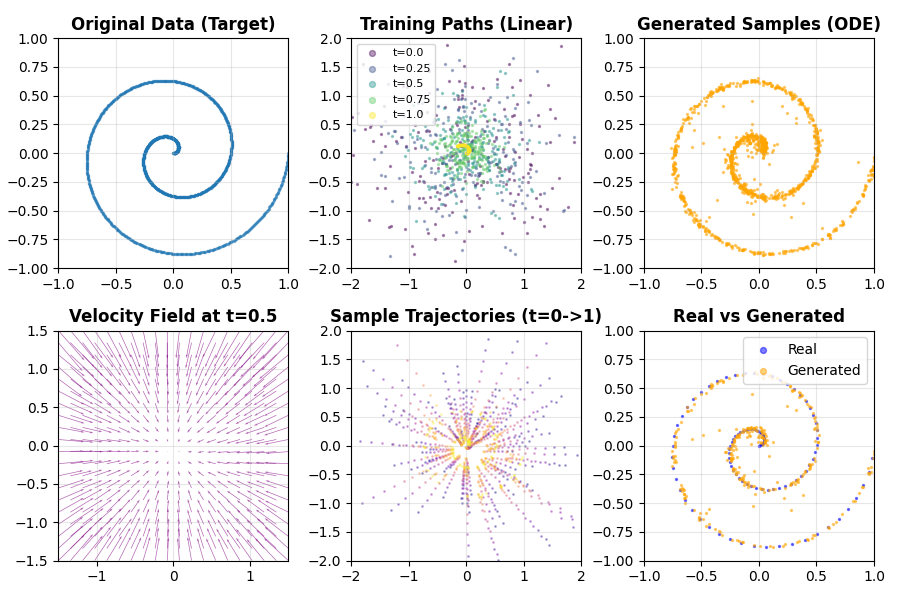

In [9]:
%matplotlib ipympl

# Static visualization
fig = visualize_results(model, data, device, n_steps=50)
plt.show()

### Animation

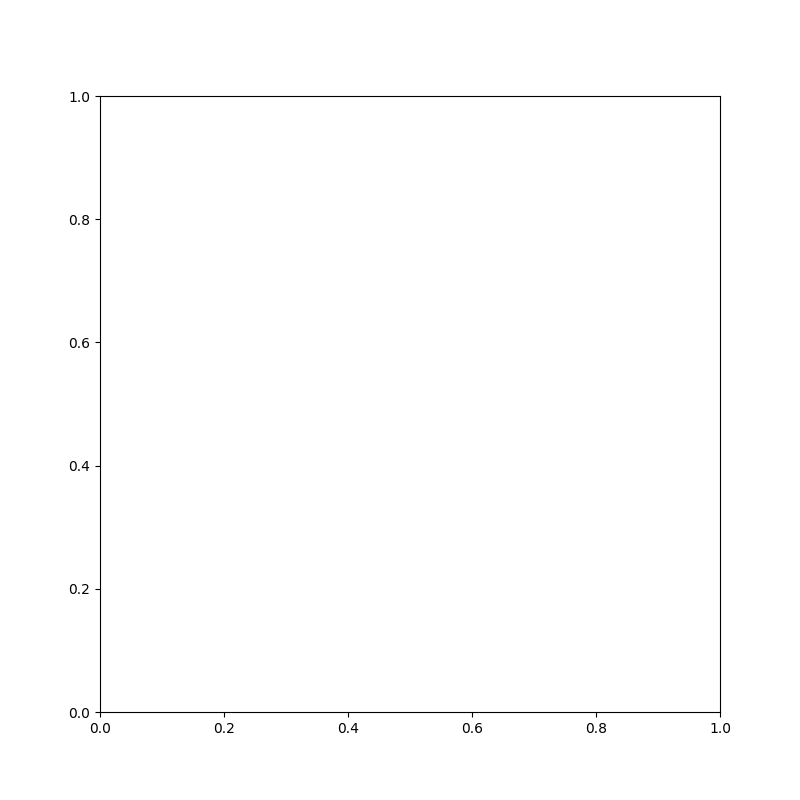

In [14]:
fig_anim, anim = create_animation(model, data, device, n_steps=100)
plt.show()